
# Coding Assignment 2

# Solving the Cauchy-Euler Differential Equation using Neural Networks in PyTorch

This notebook demonstrates solving the second-order Cauchy-Euler differential equation using both normal neural networks and Physics-Informed Neural Networks (PINNs). Analysis of how well they capture the true solution is done

## The Cauchy-Euler Equation

The Cauchy-Euler equation has the general form:

$$ x^2 \frac{d^2 y}{dx^2} + \alpha x \frac{dy}{dx} + \beta y = 0 $$

where $\alpha$ and $\beta$ are constants.



In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generating the Dataset

A synthetic dataset that includes input values of \( x \) in a certain range and corresponding \( y \) values is generated. The values of y are calulcated using the solution of the Euler-Cauchy-Equation

The solution is : $$ y = x^-0.5 * (c1 * cos(b * ln(x))) + c2*sin(b*ln(x)) $$


In [2]:
# Parameters for the analytical solution (complex roots)
a = -0.5
b = 0.5
c1, c2 = 1.0, 0.5  # Coefficients

# Defining constants for the Cauchy-Euler equation
alpha = 2.0
beta = 1.0

x_data = torch.linspace(0.1, 2.0, 1000).unsqueeze(1).to(device)

# Calculating y_data using the analytical solution
y_data = (x_data**a) * (c1 * torch.cos(b * torch.log(x_data)) + c2 * torch.sin(b * torch.log(x_data)))

#Adding noise to the dataset
noise = 0.01 * torch.randn(x_data.shape).to(device)
y_data_noisy = y_data + noise

x_tensor = x_data
y_tensor = y_data_noisy

# Splitting the data into training and testing datasets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
x_train, x_test = torch.split(x_tensor, [train_size, test_size])
y_train, y_test = torch.split(y_tensor, [train_size, test_size])

## Defining the Neural Network Model (Normal NN)

A simple feedforward neural network to predict \( y(x) \) based on the input \( x \) is made


In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

## Training the Normal Neural Network

Adam's algorithm is used to train the normal neural network.


In [4]:
model_nn = NeuralNet().to(device)

criterion = nn.MSELoss()
optimizer_nn = torch.optim.Adam(model_nn.parameters(), lr=0.0001)

epochs = 4000
loss_history_nn = []

for epoch in range(epochs):
    model_nn.train()
    optimizer_nn.zero_grad()
    output = model_nn(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer_nn.step()

    # Storing the loss history for plotting
    loss_history_nn.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



Epoch 100/4000, Loss: 0.04981396347284317
Epoch 200/4000, Loss: 0.024834496900439262
Epoch 300/4000, Loss: 0.024655066430568695
Epoch 400/4000, Loss: 0.024443455040454865
Epoch 500/4000, Loss: 0.024193020537495613
Epoch 600/4000, Loss: 0.02390189655125141
Epoch 700/4000, Loss: 0.023567412048578262
Epoch 800/4000, Loss: 0.02318638749420643
Epoch 900/4000, Loss: 0.022755395621061325
Epoch 1000/4000, Loss: 0.022271154448390007
Epoch 1100/4000, Loss: 0.021731028333306313
Epoch 1200/4000, Loss: 0.021133825182914734
Epoch 1300/4000, Loss: 0.020480766892433167
Epoch 1400/4000, Loss: 0.01977652683854103
Epoch 1500/4000, Loss: 0.01903003826737404
Epoch 1600/4000, Loss: 0.018254516646265984
Epoch 1700/4000, Loss: 0.017466261982917786
Epoch 1800/4000, Loss: 0.016681987792253494
Epoch 1900/4000, Loss: 0.015915362164378166
Epoch 2000/4000, Loss: 0.015174049884080887
Epoch 2100/4000, Loss: 0.014459079131484032
Epoch 2200/4000, Loss: 0.013766841031610966
Epoch 2300/4000, Loss: 0.013092155568301678
Ep

## Plotting the Loss Function for the Normal Neural Network

Loss function is plotted as how it changes over epochs.


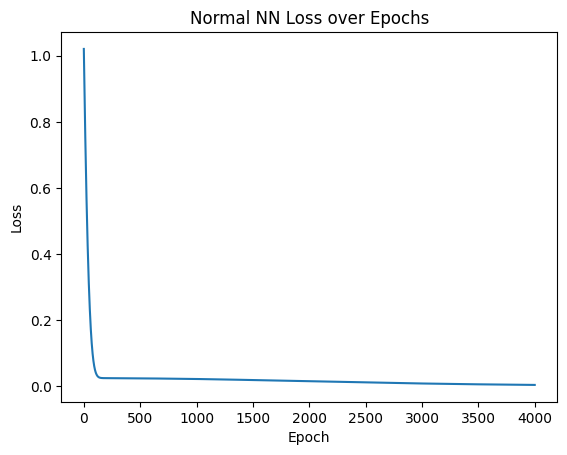

In [5]:
plt.plot(loss_history_nn)
plt.title('Normal NN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Comparing Actual Data with Predictions from Normal Neural Network


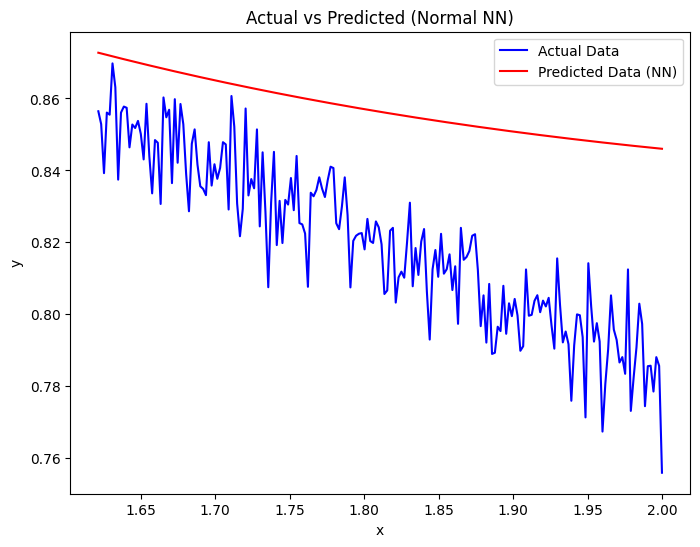

In [6]:
model_nn.eval()
y_pred_nn = model_nn(x_test).detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.plot(x_test.cpu(), y_test.cpu(), label='Actual Data', color='blue')
plt.plot(x_test.cpu(), y_pred_nn, label='Predicted Data (NN)', color='red')
plt.title('Actual vs Predicted (Normal NN)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Training the Physics-Informed Neural Network (PINN)

The PINN is trained using both the data loss (mean squared error) and the physics loss (residual from the differential equation).


In [7]:
model_pinn = NeuralNet().to(device)
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=3e-4)

criterion = nn.MSELoss()

lambda_physics = 0.0001

# Training loop for PINN
epochs = 4000
loss_history_pinn = []

for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    x_train = x_train.clone().detach().requires_grad_(True)

    # Data loss (mean squared error)
    y_pred = model_pinn(x_train)
    data_loss = criterion(y_pred, y_train)

    # Physics loss (Cauchy-Euler equation residual)
    dydx = torch.autograd.grad(y_pred, x_train, torch.ones_like(y_pred), create_graph=True)[0]
    d2ydx2 = torch.autograd.grad(dydx, x_train, torch.ones_like(dydx), create_graph=True)[0]

    physics_residual = x_train**2 * d2ydx2 + alpha * x_train * dydx + beta * y_pred
    physics_loss = torch.mean(physics_residual**2)

    total_loss = data_loss + lambda_physics * physics_loss

    total_loss.backward()
    optimizer_pinn.step()

    loss_history_pinn.append(total_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss.item()}, Data Loss: {data_loss.item()}, Physics Loss: {physics_loss.item()}')

    # Gradually increasing the influence of physics loss over the epochs so that physics loss also gets reduced!
    if epoch % 500 == 0 and epoch > 0:
        lambda_physics += 0.0001

Epoch 100/4000, Total Loss: 0.021728258579969406, Data Loss: 0.021675560623407364, Physics Loss: 0.5269783735275269
Epoch 200/4000, Total Loss: 0.020686227828264236, Data Loss: 0.020636755973100662, Physics Loss: 0.4947192370891571
Epoch 300/4000, Total Loss: 0.019359402358531952, Data Loss: 0.01931261271238327, Physics Loss: 0.46788856387138367
Epoch 400/4000, Total Loss: 0.01784837245941162, Data Loss: 0.01780308224260807, Physics Loss: 0.4529023766517639
Epoch 500/4000, Total Loss: 0.016296638175845146, Data Loss: 0.016251161694526672, Physics Loss: 0.45475754141807556
Epoch 600/4000, Total Loss: 0.014892980456352234, Data Loss: 0.014799254015088081, Physics Loss: 0.4686307907104492
Epoch 700/4000, Total Loss: 0.01361190713942051, Data Loss: 0.013515898026525974, Physics Loss: 0.4800449013710022
Epoch 800/4000, Total Loss: 0.012449011206626892, Data Loss: 0.012354036793112755, Physics Loss: 0.47487014532089233
Epoch 900/4000, Total Loss: 0.011280846782028675, Data Loss: 0.0111901815

## Plotting the Loss Function for the Physics-Informed Neural Network (PINN)


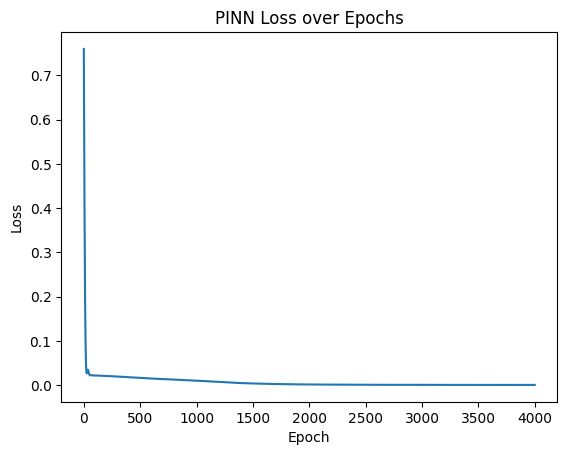

In [8]:
plt.plot(loss_history_pinn)
plt.title('PINN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Comparing Actual Data with Predictions from PINN


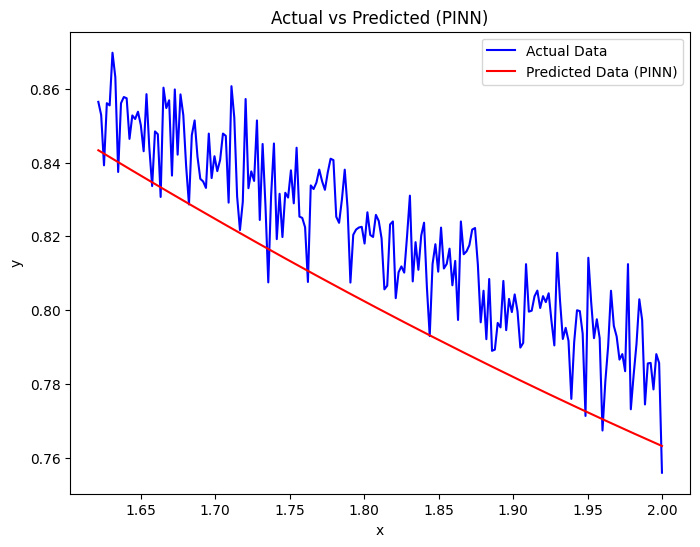

In [9]:
model_pinn.eval()
with torch.no_grad():
    y_pred_pinn = model_pinn(x_test).cpu().numpy()

plt.figure(figsize=(8, 6))
plt.plot(x_test.cpu(), y_test.cpu(), label='Actual Data', color='blue')
plt.plot(x_test.cpu(), y_pred_pinn, label='Predicted Data (PINN)', color='red')
plt.title('Actual vs Predicted (PINN)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Evaluation and Comparison

Both the models are now compared on a same plot to check how good they get along with the actual dataset


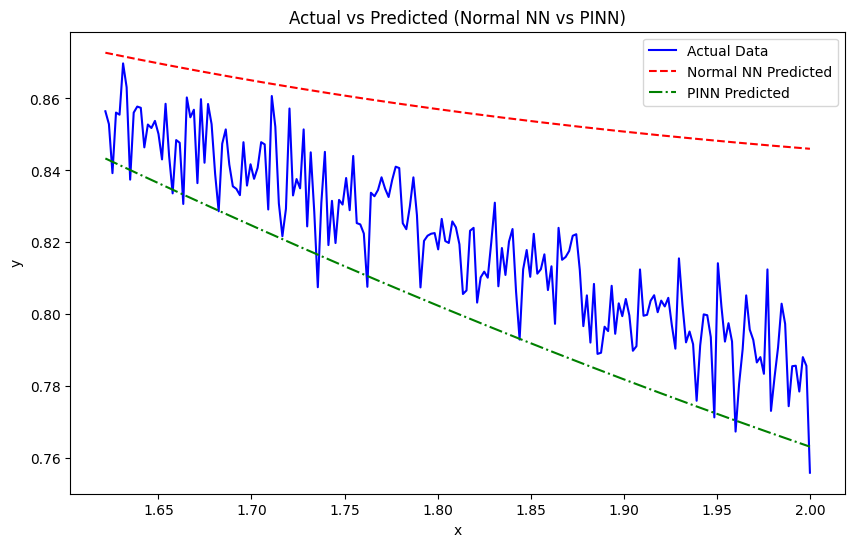

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x_test.cpu(), y_test.cpu(), label='Actual Data', color='blue')
plt.plot(x_test.cpu(), y_pred_nn, label='Normal NN Predicted', color='red', linestyle='--')
plt.plot(x_test.cpu(), y_pred_pinn, label='PINN Predicted', color='green', linestyle='-.')
plt.title('Actual vs Predicted (Normal NN vs PINN)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
